In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from reservoirpy import set_seed, verbosity
from reservoirpy.nodes import Reservoir, Ridge, Input
from reservoirpy.datasets import japanese_vowels

In [7]:
set_seed(42)
verbosity(0)

0

In [8]:
train_sample=1

X_train, Y_train, X_test, Y_test = japanese_vowels(repeat_targets=True)

sampled_indices = np.random.choice(len(X_train), size=int(len(X_train) * train_sample), replace=False)
X_train = [X_train[i] for i in sampled_indices]
Y_train = [Y_train[i] for i in sampled_indices]

X_train_shuffled = [seq[np.random.permutation(len(seq))] for seq in X_train]
X_test_shuffled = [seq[np.random.permutation(len(seq))] for seq in X_test]


In [10]:
train_lengths = [len(signal) for signal in X_train]
test_lengths = [len(signal) for signal in X_test]

print(np.unique(train_lengths, return_counts=True))
print(np.unique(test_lengths, return_counts=True))

(array([ 7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26]), array([ 1,  2, 10, 18, 22, 21, 22, 41, 28, 27, 22, 13,  8, 14,  5, 11,  2,
        2,  1], dtype=int64))
(array([ 7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 29]), array([ 1,  8, 15, 26, 31, 43, 45, 38, 38, 35, 25, 11, 16, 14,  8,  5,  6,
        3,  1,  1], dtype=int64))


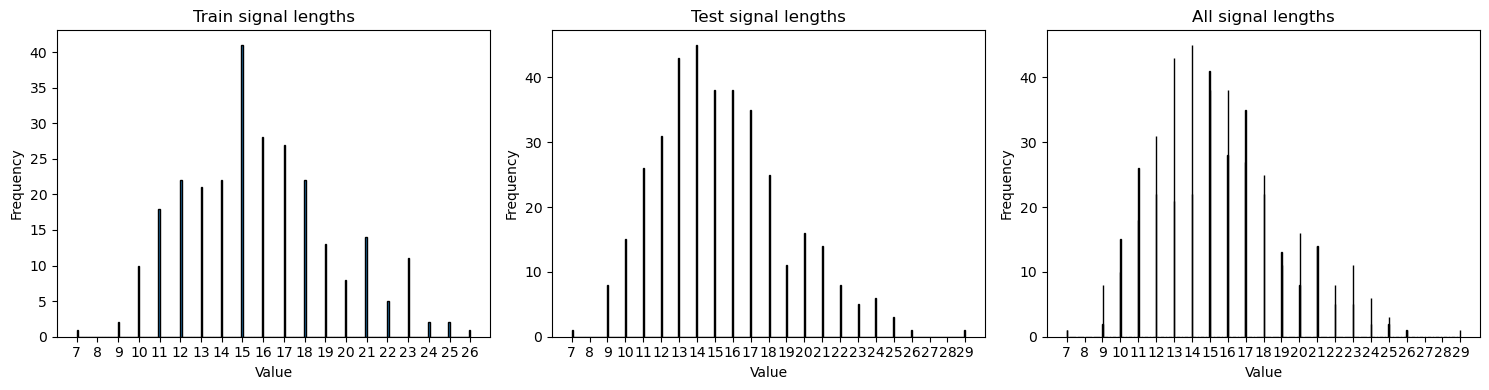

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train_lengths, bins=len(train_lengths), edgecolor='black')
axes[0].set_title('Train signal lengths')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(min(train_lengths), max(train_lengths)+1))  # set integer ticks

axes[1].hist(test_lengths, bins=len(test_lengths), edgecolor='black')
axes[1].set_title('Test signal lengths')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(min(test_lengths), max(test_lengths)+1)) 

axes[2].hist([train_lengths, test_lengths], bins=len(train_lengths)+len(test_lengths), edgecolor='black')
axes[2].set_title('All signal lengths')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].set_xticks(range(min(train_lengths), max(test_lengths)+1)) 

plt.tight_layout()
plt.show()

In [39]:
trunc = 10

# Collect indices of signals with >=14 timesteps
train_keep_idx = [i for i, signal in enumerate(X_train) if signal.shape[0] >= trunc]
test_keep_idx  = [i for i, signal in enumerate(X_test)  if signal.shape[0] >= trunc]

# Use indices to filter X and Y uniformly
X_train_filtered = [X_train[i] for i in train_keep_idx]
Y_train_filtered = [Y_train[i] for i in train_keep_idx]

X_test_filtered  = [X_test[i]  for i in test_keep_idx]
Y_test_filtered  = [Y_test[i]  for i in test_keep_idx]

# Now truncate all signals to 14 timesteps
X_train_filtered = [signal[:trunc, :] for signal in X_train_filtered]
Y_train_filtered = [signal[:trunc, :] for signal in Y_train_filtered]

X_test_filtered  = [signal[:trunc, :] for signal in X_test_filtered]
Y_test_filtered  = [signal[:trunc, :] for signal in Y_test_filtered]

print(f'Dropped signals (train): {len(X_train) - len(X_train_filtered)}')
print(f'Dropped signals (test): {len(X_test) - len(X_train_filtered)}')


Dropped signals (train): 3
Dropped signals (test): 103


In [40]:
train_class_count = [np.argmax(signal[0,:]) for signal in Y_train_filtered]
test_class_count = [np.argmax(signal[0,:]) for signal in Y_test_filtered]

print(np.unique(train_class_count, return_counts=True))
print(np.unique(test_class_count, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([30, 30, 28, 30, 30, 30, 30, 30, 29], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([31, 35, 81, 44, 28, 24, 40, 49, 29], dtype=int64))


# Basic ESN

In [139]:
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = [source >> reservoir] >> readout

In [140]:
Y_pred = model.fit(X_train, Y_train, stateful=False, warmup=2).run(X_test_shuffled, stateful=False)

In [141]:
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in Y_test]

score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  73.976 %


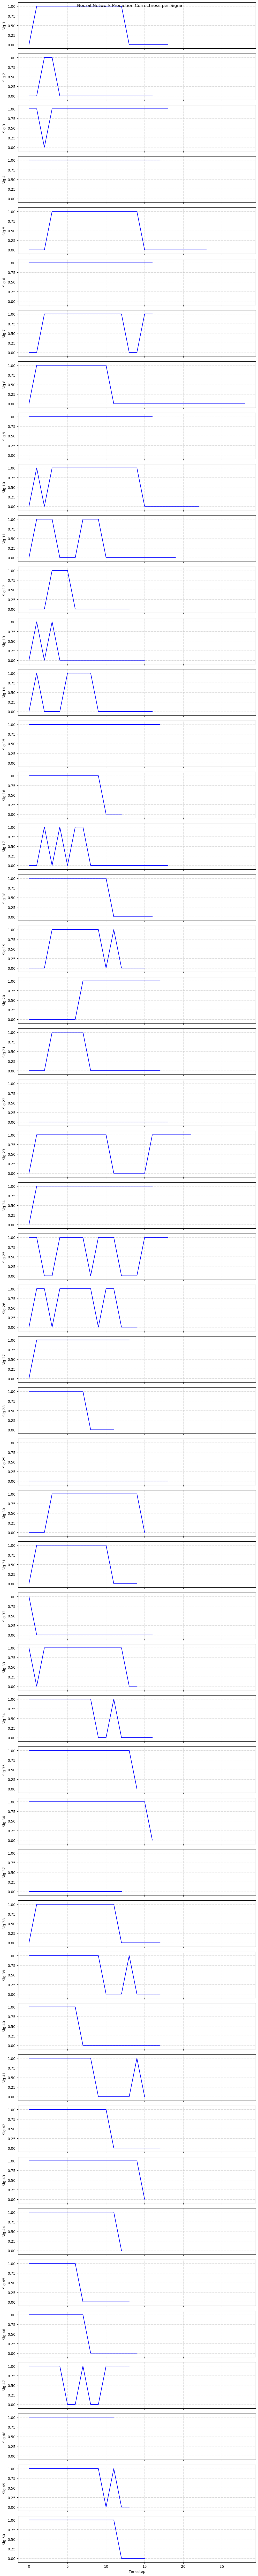

In [142]:
def plot_correctness_stacked(predictions, targets):
    num_signals = len(predictions)
    fig, axes = plt.subplots(num_signals, 1, figsize=(10, 2*num_signals), sharex=True)
    
    # If only one signal, axes won't be a list — make it a list for consistency
    if num_signals == 1:
        axes = [axes]
    
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        correctness = (pred == target).astype(int)
        timesteps = np.arange(len(pred))
        
        axes[i].plot(timesteps, correctness, color='blue')
        axes[i].set_ylabel(f"Sig {i+1}")
        axes[i].set_ylim(-0.1, 1.1)
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    axes[-1].set_xlabel("Timestep")
    fig.suptitle("Neural Network Prediction Correctness per Signal", y=0.995)
    plt.tight_layout()
    plt.show()

plot_correctness_stacked(Y_pred_class[:50], Y_test_class[:50])